In [2]:
##code to generate the files needed for the tests
import random
import csv

# ------------------------
# 1. Define placeholder pools
# ------------------------
names = ["Alice", "Bob", "Charlie", "Diana", "Eve", "Frank", "Grace", "Hank",
         "Ivy", "Jack", "Kara", "Leo", "Mona", "Nina", "Oscar", "Paul",
         "Quinn", "Rita", "Sam", "Tina", "Uma", "Victor", "Wendy", "Xander",
         "Yara", "Zane"]

traits = ["happy", "sad", "tall", "short", "kind", "angry", "brave", "calm",
          "clever", "curious", "gentle", "honest", "lazy", "loud", "polite",
          "proud", "quiet", "rude", "shy", "smart"]

# ------------------------
# 2. Define reasoning pattern templates
# ------------------------
templates = {
    "Modus Ponens": "If {X} is {P}, then {Y} is {Q}. {X} is {P}. Is {Y} {Q}?",
    "Modus Tollens": "If {X} is {P}, then {Y} is {Q}. {Y} is not {Q}. Is {X} not {P}?",
    "Affirming the Consequent": "If {X} is {P}, then {Y} is {Q}. {Y} is {Q}. Is {X} {P}?",
    "Denying the Antecedent": "If {X} is {P}, then {Y} is {Q}. {X} is not {P}. Is {Y} not {Q}?"
}

validity_map = {
    "Modus Ponens": "Yes",
    "Modus Tollens": "Yes",
    "Affirming the Consequent": "No",
    "Denying the Antecedent": "No"
}

# ------------------------
# 3. Example generator
# ------------------------
def generate_examples(pattern, n=500):
    template = templates[pattern]
    examples = set()

    while len(examples) < n:
        X, Y = random.sample(names, 2)  # ensure X != Y
        P = random.choice(traits)
        Q = random.choice([t for t in traits if t != P])  # avoid trivial P=Q
        sentence = template.format(X=X, Y=Y, P=P, Q=Q)
        examples.add(sentence)

    return [{"text_input": s,
             "reasoning_class": pattern,
             "validity": validity_map[pattern]} for s in examples]

# ------------------------
# 4. Generate dataset
# ------------------------
dataset = []
for pattern in templates:
    dataset.extend(generate_examples(pattern, n=500))

print(f"Total examples generated: {len(dataset)}")  # should be 2000

# ------------------------
# 5. Save to CSV
# ------------------------
csv_file = "reasoning_patterns_dataset.csv"
with open(csv_file, mode="w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["text_input", "reasoning_class", "validity"])
    writer.writeheader()
    for ex in dataset:
        writer.writerow(ex)

print(f"Dataset saved to {csv_file}")


Total examples generated: 2000
Dataset saved to reasoning_patterns_dataset.csv


/var/folders/y7/ksm3w2x51tg346z69g9q4_p00000gn/T/ipykernel_17549/3204985365.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  return [torch.tensor(layer) for layer in all_layers]


Layer 0: 0.250
Layer 1: 0.495
Layer 2: 0.492
Layer 3: 0.708
Layer 4: 0.828
Layer 5: 0.895
Layer 6: 0.917
Layer 7: 0.963
Layer 8: 0.968
Layer 9: 0.968
Layer 10: 0.980
Layer 11: 0.970
Layer 12: 0.953


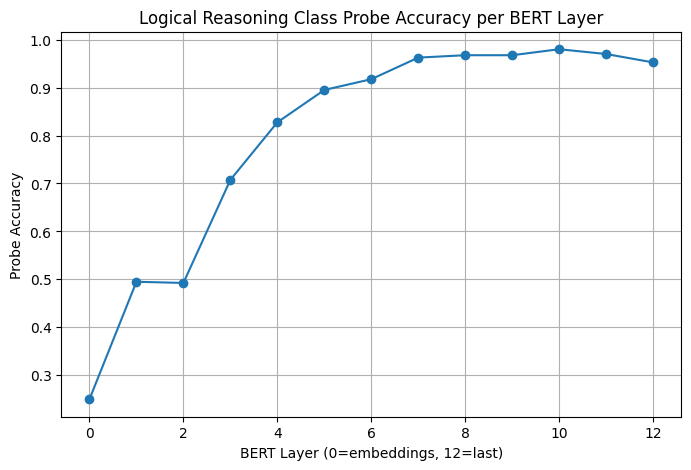

In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ------------------------
# 1. Load your dataset
# ------------------------
df = pd.read_csv("reasoning_patterns_dataset.csv")
texts = df["text_input"].tolist()
labels = df["reasoning_class"].astype("category").cat.codes.tolist()  
# classes: 0=MP, 1=MT, 2=AC, 3=DA

# ------------------------
# 2. Load BERT
# ------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True).to(device)
model.eval()

# ------------------------
# 3. Encode texts & extract CLS per layer
# ------------------------
def get_cls_embeddings(texts, batch_size=16):
    all_layers = [[] for _ in range(13)]  # 0 = embedding layer, 1-12 = hidden layers
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = model(**enc)
            hidden_states = outputs.hidden_states  # tuple of (13, batch, seq_len, hidden_dim)

            for layer_i, layer_hidden in enumerate(hidden_states):
                cls_vecs = layer_hidden[:, 0, :].cpu().numpy()
                all_layers[layer_i].extend(cls_vecs)

    return [torch.tensor(layer) for layer in all_layers]

all_layer_embeddings = get_cls_embeddings(texts)

# ------------------------
# 4. Train probes (logistic regression per layer)
# ------------------------
results = []
for layer_i, X in enumerate(all_layer_embeddings):
    X_train, X_test, y_train, y_test = train_test_split(
        X.numpy(), labels, test_size=0.2, random_state=42, stratify=labels
    )
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    results.append(acc)
    print(f"Layer {layer_i}: {acc:.3f}")

# ------------------------
# 5. Plot accuracy vs. layer
# ------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(13), results, marker="o")
plt.xlabel("BERT Layer (0=embeddings, 12=last)")
plt.ylabel("Probe Accuracy")
plt.title("Logical Reasoning Class Probe Accuracy per BERT Layer")
plt.grid(True)
plt.show()
